In [134]:
from tqdm import tqdm
import torch
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

OUTPUT_DIR = "./output/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_theta_torch(x, y):
    theta = torch.where(y < 0, (-1) * torch.atan2(y, x), 2 * math.pi - torch.atan2(y, x))
    return theta

def create_equirectangler_to_bottom_and_top_map(input_w, input_h, output_sqr, z):
    x, y = torch.meshgrid(torch.linspace(-output_sqr/2.0, output_sqr/2.0-1, output_sqr), 
                          torch.linspace(-output_sqr/2.0, output_sqr/2.0-1, output_sqr), indexing="ij")
    x, y = x.to(device), y.to(device)
    z = torch.tensor(z).to(device)
    
    rho = torch.sqrt(x**2 + y**2 + z**2)
    norm_theta = get_theta_torch(x, y) / (2 * math.pi)
    norm_phi = (math.pi - torch.acos(z / rho)) / math.pi
    ix = norm_theta * input_w
    iy = norm_phi * input_h

    # Boundary handling
    ix = torch.where(ix >= input_w, ix - input_w, ix)
    iy = torch.where(iy >= input_h, iy - input_h, iy)
    
    return ix.cpu().numpy(), iy.cpu().numpy()

# We'll replicate the above approach for the other functions as well
def create_equirectangler_to_front_and_back_map(input_w, input_h, output_sqr, x):
    z, y = torch.meshgrid(torch.linspace(-output_sqr/2.0, output_sqr/2.0-1, output_sqr), 
                          torch.linspace(-output_sqr/2.0, output_sqr/2.0-1, output_sqr), indexing="ij")
    z, y = z.to(device), y.to(device)
    x = torch.tensor(x).to(device)
    
    rho = torch.sqrt(x**2 + y**2 + z**2)
    norm_theta = get_theta_torch(x, y) / (2 * math.pi)
    norm_phi = (math.pi - torch.acos(z / rho)) / math.pi
    ix = norm_theta * input_w
    iy = norm_phi * input_h

    # Boundary handling
    ix = torch.where(ix >= input_w, ix - input_w, ix)
    iy = torch.where(iy >= input_h, iy - input_h, iy)
    
    return ix.cpu().numpy(), iy.cpu().numpy()

def create_equirectangler_to_left_and_right_map(input_w, input_h, output_sqr, y):
    x, z = torch.meshgrid(torch.linspace(-output_sqr/2.0, output_sqr/2.0-1, output_sqr), 
                          torch.linspace(-output_sqr/2.0, output_sqr/2.0-1, output_sqr), indexing="ij")
    x, z = x.to(device), z.to(device)
    y = torch.tensor(y).to(device)
    
    rho = torch.sqrt(x**2 + y**2 + z**2)
    norm_theta = get_theta_torch(x, y) / (2 * math.pi)
    norm_phi = (math.pi - torch.acos(z / rho)) / math.pi
    ix = norm_theta * input_w
    iy = norm_phi * input_h

    # Boundary handling
    ix = torch.where(ix >= input_w, ix - input_w, ix)
    iy = torch.where(iy >= input_h, iy - input_h, iy)
    
    return ix.cpu().numpy(), iy.cpu().numpy()


def create_cube_map(back_img, bottom_img, front_img, left_img, right_img, top_img, output_sqr):
    cube_map_img = np.zeros((3 * output_sqr, 4 * output_sqr, 3))
    cube_map_img[output_sqr:2*output_sqr, 3*output_sqr:4*output_sqr] = back_img
    cube_map_img[2*output_sqr:3*output_sqr, 0:output_sqr] = bottom_img
    cube_map_img[output_sqr:2*output_sqr, output_sqr:2*output_sqr] = front_img
    cube_map_img[output_sqr:2*output_sqr, 0:output_sqr] = left_img
    cube_map_img[output_sqr:2*output_sqr, 2*output_sqr:3*output_sqr] = right_img
    cube_map_img[0:output_sqr, 0:output_sqr] = top_img
    return cube_map_img


def create_cube_map2(back_img, bottom_img, front_img, left_img, right_img, top_img, output_sqr):
    cube_map_img = np.zeros((3 * output_sqr, 4 * output_sqr, 3))
    cube_map_img[output_sqr:2*output_sqr, 3*output_sqr:4*output_sqr] = back_img
    cube_map_img[2*output_sqr:3*output_sqr, output_sqr:2*output_sqr] = bottom_img
    cube_map_img[output_sqr:2*output_sqr, output_sqr:2*output_sqr] = front_img
    cube_map_img[output_sqr:2*output_sqr, 0:output_sqr] = left_img
    cube_map_img[output_sqr:2*output_sqr, 2*output_sqr:3*output_sqr] = right_img
    cube_map_img[0:output_sqr, output_sqr:2*output_sqr] = top_img
    return cube_map_img


def create_cube_imgs(img):
    input_h, input_w, _ = img.shape
    output_sqr = int(input_w / 4)
    normalized_f = 1

    z = (output_sqr / (2.0 * normalized_f))
    bottom_map_x, bottom_map_y = create_equirectangler_to_bottom_and_top_map(input_w, input_h, output_sqr, z)
    bottom_img = cv2.remap(img, bottom_map_x.astype("float32"), bottom_map_y.astype("float32"), cv2.INTER_CUBIC)
    #bottom_img = cv2.rotate(bottom_img, cv2.ROTATE_90_CLOCKWISE)

    z = (-1) * (output_sqr / (2.0 * normalized_f))
    top_map_x, top_map_y = create_equirectangler_to_bottom_and_top_map(input_w, input_h, output_sqr, z)
    top_img = cv2.remap(img, top_map_x.astype("float32"), top_map_y.astype("float32"), cv2.INTER_CUBIC)
    top_img = cv2.flip(top_img, 0)
    #top_img = cv2.rotate(top_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    x = (-1) * (output_sqr / (2.0 * normalized_f))
    front_map_x, front_map_y = create_equirectangler_to_front_and_back_map(input_w, input_h, output_sqr, x)
    front_img = cv2.remap(img, front_map_x.astype("float32"), front_map_y.astype("float32"), cv2.INTER_CUBIC)

    x = output_sqr / (2.0 * normalized_f)
    back_map_x, back_map_y = create_equirectangler_to_front_and_back_map(input_w, input_h, output_sqr, x)
    back_img = cv2.remap(img, back_map_x.astype("float32"), back_map_y.astype("float32"), cv2.INTER_CUBIC)
    back_img = cv2.flip(back_img, 1)

    y = (-1) * (output_sqr / (2.0 * normalized_f))
    left_map_x, left_map_y = create_equirectangler_to_left_and_right_map(input_w, input_h, output_sqr, y)
    left_img = cv2.remap(img, left_map_x.astype("float32"), left_map_y.astype("float32"), cv2.INTER_CUBIC)
    left_img = cv2.rotate(left_img, cv2.ROTATE_90_CLOCKWISE)

    y = output_sqr / (2.0 * normalized_f)
    right_map_x, right_map_y = create_equirectangler_to_left_and_right_map(input_w, input_h, output_sqr, y)
    right_img = cv2.remap(img, right_map_x.astype("float32"), right_map_y.astype("float32"), cv2.INTER_CUBIC)
    right_img = cv2.flip(right_img, 1)
    right_img = cv2.rotate(right_img, cv2.ROTATE_90_COUNTERCLOCKWISE)


    return [back_img, bottom_img, front_img, left_img, right_img, top_img], output_sqr


def main(image_path):
    img = cv2.imread(image_path)
    [back_img, bottom_img, front_img, left_img, right_img, top_img], output_sqr = create_cube_imgs(img)
    cube_map_img = create_cube_map2(back_img, bottom_img, front_img, left_img, right_img, top_img, output_sqr)

    cv2.imwrite(f"{OUTPUT_DIR}bottom.png", bottom_img)
    cv2.imwrite(f"{OUTPUT_DIR}top.png", top_img)
    cv2.imwrite(f"{OUTPUT_DIR}front.png", front_img)
    cv2.imwrite(f"{OUTPUT_DIR}back.png", back_img)
    cv2.imwrite(f"{OUTPUT_DIR}left.png", left_img)
    cv2.imwrite(f"{OUTPUT_DIR}right.png", right_img)
    cv2.imwrite(f"{OUTPUT_DIR}cube_map.png", cube_map_img)
    return

In [135]:
if __name__ == "__main__":
    image_path = "O.jpg"
    main(image_path)

In [136]:
img = cv2.imread(image_path)
[back_img, bottom_img, front_img, left_img, right_img, top_img], output_sqr = create_cube_imgs(img)

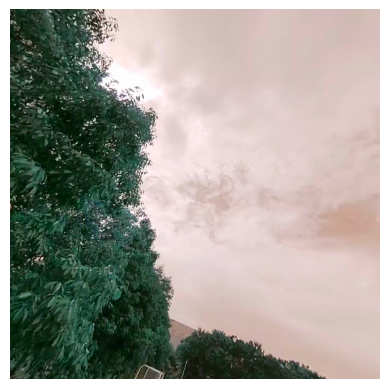

In [137]:
plt.imshow(front_img.astype('uint8'))
plt.axis("off")
plt.show()

In [138]:
back_img

array([[[ 21,  38,  24],
        [ 22,  39,  25],
        [ 25,  40,  26],
        ...,
        [ 29,  46,  43],
        [ 32,  49,  46],
        [ 35,  52,  49]],

       [[ 23,  40,  26],
        [ 28,  45,  31],
        [ 30,  47,  33],
        ...,
        [ 33,  50,  47],
        [ 37,  54,  51],
        [ 40,  57,  54]],

       [[ 22,  39,  25],
        [ 28,  45,  31],
        [ 33,  50,  36],
        ...,
        [ 33,  50,  47],
        [ 37,  54,  51],
        [ 44,  61,  58]],

       ...,

       [[ 42,  63,  60],
        [ 50,  71,  68],
        [ 56,  76,  73],
        ...,
        [174, 159, 160],
        [174, 160, 161],
        [172, 159, 161]],

       [[ 51,  73,  70],
        [ 53,  74,  70],
        [ 57,  78,  74],
        ...,
        [174, 160, 161],
        [175, 162, 163],
        [175, 162, 164]],

       [[ 52,  75,  70],
        [ 52,  76,  70],
        [ 56,  78,  74],
        ...,
        [175, 161, 162],
        [176, 162, 163],
        [177, 163, 165]]

In [139]:
equirect_width, equirect_height = 3840, 1920
# キューブマップの各面のサイズを取得
cube_size = back_img.shape[-1]

# 全天球画像の座標を生成
theta, phi = torch.meshgrid(torch.linspace(0, 2 * math.pi, equirect_width), 
                            torch.linspace(0, math.pi, equirect_height), indexing="ij")

# 球から直交座標に変換
x = torch.sin(phi) * torch.cos(theta)
y = torch.sin(phi) * torch.sin(theta)
z = torch.cos(phi)

# 各座標をキューブマップのどの面を参照するかを決定
mask_back = (x <= -0.5)
mask_front = (x >= 0.5)
mask_left = (y <= -0.5)
mask_right = (y >= 0.5)
mask_top = (z >= 0.5)
mask_bottom = (z <= -0.5)

In [140]:
# 結果を格納するテンソルを初期化
equirect_img = torch.zeros((3, equirect_width, equirect_height))

top_img_t = torch.tensor(top_img, dtype=torch.float32).permute(2, 1, 0)
# top face
x_idx = torch.round((y[mask_top] + 0.5) * (cube_size-1)).long()
y_idx = torch.round((x[mask_top] + 0.5) * (cube_size-1)).long()
# Ensure the indices are within valid range
x_idx = torch.clamp(x_idx, 0, cube_size-1)
y_idx = torch.clamp(y_idx, 0, cube_size-1)
equirect_img[:, mask_top] = top_img_t[:, x_idx, y_idx]

In [141]:
equirect_img[:, mask_back] = 1

In [142]:
equirect_img.shape

torch.Size([3, 3840, 1920])

In [143]:
mask_top

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

In [144]:
equirect_img

tensor([[[30., 30., 30.,  ...,  0.,  0.,  0.],
         [30., 30., 30.,  ...,  0.,  0.,  0.],
         [30., 30., 30.,  ...,  0.,  0.,  0.],
         ...,
         [30., 30., 30.,  ...,  0.,  0.,  0.],
         [30., 30., 30.,  ...,  0.,  0.,  0.],
         [30., 30., 30.,  ...,  0.,  0.,  0.]],

        [[47., 47., 47.,  ...,  0.,  0.,  0.],
         [47., 47., 47.,  ...,  0.,  0.,  0.],
         [47., 47., 47.,  ...,  0.,  0.,  0.],
         ...,
         [47., 47., 47.,  ...,  0.,  0.,  0.],
         [47., 47., 47.,  ...,  0.,  0.,  0.],
         [47., 47., 47.,  ...,  0.,  0.,  0.]],

        [[44., 44., 44.,  ...,  0.,  0.,  0.],
         [44., 44., 44.,  ...,  0.,  0.,  0.],
         [44., 44., 44.,  ...,  0.,  0.,  0.],
         ...,
         [44., 44., 44.,  ...,  0.,  0.,  0.],
         [44., 44., 44.,  ...,  0.,  0.,  0.],
         [44., 44., 44.,  ...,  0.,  0.,  0.]]])

In [145]:
equirect_img.shape

torch.Size([3, 3840, 1920])

In [146]:
# 1. Convert the tensor to a numpy array
equirect_np = equirect_img.permute(2, 1, 0).cpu().numpy()
# 2. Convert the data type to uint8
#equirect_np = (equirect_np).astype(np.uint8)

# 3. Change color channels from RGB to BGR
#equirect_np = cv2.cvtColor(equirect_np, cv2.COLOR_RGB2BGR)

# 4. Show the image using OpenCV
#cv2.imshow('Equirectangular Image', equirect_np)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


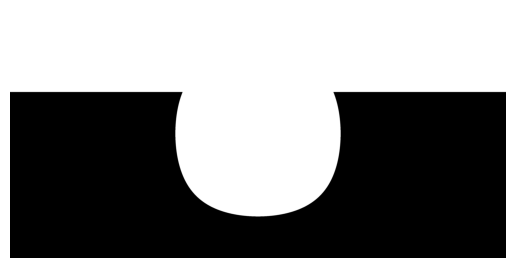

In [147]:
import matplotlib.pyplot as plt
plt.imshow(equirect_np)
plt.axis("off")
plt.show()

In [148]:
def cube_to_equirectangular(back_img, bottom_img, front_img, left_img, right_img, top_img, equirect_width, equirect_height):
    # キューブマップの各面の画像をtorch.Tensorに変換
    back_img = torch.tensor(back_img, dtype=torch.float32).permute(2, 1, 0)
    bottom_img = torch.tensor(bottom_img, dtype=torch.float32).permute(2, 1, 0)
    front_img = torch.tensor(front_img, dtype=torch.float32).permute(2, 1, 0)
    left_img = torch.tensor(left_img, dtype=torch.float32).permute(2, 1, 0)
    right_img = torch.tensor(right_img, dtype=torch.float32).permute(2, 1, 0)
    top_img = torch.tensor(top_img, dtype=torch.float32).permute(2, 1, 0)

    
    # キューブマップの各面のサイズを取得
    cube_size = back_img.shape[-1]
    
    # 全天球画像の座標を生成
    theta, phi = torch.meshgrid(torch.linspace(0, 2 * math.pi, equirect_width), 
                                torch.linspace(0, math.pi, equirect_height), indexing="ij")
    
    # 球から直交座標に変換
    x = torch.sin(phi) * torch.cos(theta)
    y = torch.sin(phi) * torch.sin(theta)
    z = torch.cos(phi)
    
    # 各座標をキューブマップのどの面を参照するかを決定
    mask_back = (x <= -0.5)
    mask_front = (x >= 0.5)
    mask_left = (y <= -0.5)
    mask_right = (y >= 0.5)
    mask_top = (z >= 0.5)
    mask_bottom = (z <= -0.5)
    
    # 結果を格納するテンソルを初期化
    equirect_img = torch.zeros((3, equirect_width, equirect_height))
    
    # back face
    x_idx = torch.round((-y[mask_back] + 0.5) * (cube_size-1)).long()
    y_idx = torch.round((-x[mask_back] + 0.5) * (cube_size-1)).long()
    # Ensure the indices are within valid range
    x_idx = torch.clamp(x_idx, 0, cube_size-1)
    y_idx = torch.clamp(y_idx, 0, cube_size-1)
    equirect_img[:, mask_back] = back_img[:, x_idx, y_idx]

    
    # front face
    x_idx = torch.round((y[mask_front] + 0.5) * (cube_size-1)).long()
    y_idx = torch.round((x[mask_front] + 0.5) * (cube_size-1)).long()
    # Ensure the indices are within valid range
    x_idx = torch.clamp(x_idx, 0, cube_size-1)
    y_idx = torch.clamp(y_idx, 0, cube_size-1)
    equirect_img[:, mask_front] = front_img[:, x_idx, y_idx]
    
    # left face
    x_idx = torch.round((-z[mask_left] + 0.5) * (cube_size-1)).long()
    y_idx = torch.round((x[mask_left] + 0.5) * (cube_size-1)).long()
    # Ensure the indices are within valid range
    x_idx = torch.clamp(x_idx, 0, cube_size-1)
    y_idx = torch.clamp(y_idx, 0, cube_size-1)
    equirect_img[:, mask_left] = left_img[:, x_idx, y_idx]
    
    # right face
    x_idx = torch.round((-z[mask_right] + 0.5) * (cube_size-1)).long()
    y_idx = torch.round((-y[mask_right] + 0.5) * (cube_size-1)).long()
    # Ensure the indices are within valid range
    x_idx = torch.clamp(x_idx, 0, cube_size-1)
    y_idx = torch.clamp(y_idx, 0, cube_size-1)
    equirect_img[:, mask_right] = right_img[:, x_idx, y_idx]
    
    # top face
    x_idx = torch.round((y[mask_top] + 0.5) * (cube_size-1)).long()
    y_idx = torch.round((x[mask_top] + 0.5) * (cube_size-1)).long()
    # Ensure the indices are within valid range
    x_idx = torch.clamp(x_idx, 0, cube_size-1)
    y_idx = torch.clamp(y_idx, 0, cube_size-1)
    equirect_img[:, mask_top] = top_img[:, x_idx, y_idx]
    
    # bottom face
    x_idx = torch.round((-y[mask_bottom] + 0.5) * (cube_size-1)).long()
    y_idx = torch.round((x[mask_bottom] + 0.5) * (cube_size-1)).long()
    # Ensure the indices are within valid range
    x_idx = torch.clamp(x_idx, 0, cube_size-1)
    y_idx = torch.clamp(y_idx, 0, cube_size-1)
    equirect_img[:, mask_bottom] = bottom_img[:, x_idx, y_idx]
    
    return equirect_img


In [12]:
eq_img = cube_to_equirectangular(back_img, bottom_img, front_img, left_img, right_img, top_img, 3840, 1920)

In [13]:
eq_img.shape

torch.Size([3, 3840, 1920])

In [14]:
# 1. Convert the tensor to a numpy array
equirect_np = eq_img.permute(2, 1, 0).cpu().numpy()

# 2. Convert the data type to uint8
equirect_np = (equirect_np * 255).astype(np.uint8)

# 3. Change color channels from RGB to BGR
#equirect_np = cv2.cvtColor(equirect_np, cv2.COLOR_RGB2BGR)

# 4. Show the image using OpenCV
cv2.imshow('Equirectangular Image', equirect_np)
cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is not the object's thread (0x44086fd0).
Cannot move to target thread (0x42e06fc0)

QObject::moveToThread: Current thread (0x42e06fc0) is n

In [9]:
equirect_np.shape

(3840, 1920, 3)

In [103]:
##
# @brief 3次元座標群取得関数
# @details 360度画像の緯度経度が半径1の球の3次元座標のどこにマッピングされるか
# @param img_w 360度画像の幅
# @param img_h 360度画像の高さ
# @return x,y,zの座標群
def create_3dmap_from_size(img_w, img_h):
 
    h = np.linspace(-np.pi/2, np.pi/2, img_h, endpoint=False)
    w = np.linspace(-np.pi, np.pi, img_w, endpoint=False)
     
    # 配列を対称形にするためのオフセット
    h = h + (np.pi/2) / img_h
    w = w + np.pi / img_w
     
    theta, phi = np.meshgrid(w, h)
 
    x = np.cos(phi) * np.cos(theta)
    y = np.cos(phi) * np.sin(theta)
    z = np.sin(phi)
 
    return x, y, z



In [173]:
def create_3dmap_from_size_torch(img_w, img_h, device):
    # np.linspaceをtorch.linspaceに置き換え
    h = torch.linspace(-np.pi/2, np.pi/2, img_h, device=device)
    w = torch.linspace(-np.pi, np.pi, img_w, device=device)
    
    # オフセットの追加
    h += (np.pi/2) / img_h
    w += np.pi / img_w
    
    # np.meshgridをtorch.meshgridに置き換え
    theta, phi = torch.meshgrid(w, h)
    
    # 3D座標の計算
    x = torch.cos(phi) * torch.cos(theta)
    y = torch.cos(phi) * torch.sin(theta)
    z = torch.sin(phi)
    
    return x, y, z

In [174]:
cube_img = cv2.imread("output/cube_map.png")

In [165]:
import torch
import numpy as np

def padding_cube(img, device):
    # Convert input numpy array to PyTorch tensor
    img_tensor = torch.tensor(img).to(device).permute(0, 1, 2)
    
    h, w, c = img_tensor.shape
    cw = w // 4
    print(h, w, c)
    
    # Initialize canvas tensor
    canvas = torch.zeros((h+4, w+4, c), dtype=img_tensor.dtype, device=device)
    canvas[2:-2, 2:-2,:] = img_tensor
    
    # up    
    canvas[0:2, cw+2:2*cw+2,:] = torch.rot90(img_tensor[cw:cw+2, 3*cw:,:], 2, [0,1])
    # bottom
    canvas[-2:, cw+2:2*cw+2,:] = torch.rot90(img_tensor[2*cw-2:2*cw, 3*cw:,:], 2, [0,1])
    # left
    canvas[cw+2:2*cw+2, 0:2,:] = img_tensor[cw:2*cw, -2:,:]
    # right
    canvas[cw+2:2*cw+2, -2:,:] = img_tensor[cw:2*cw, 0:2,:]

    # Rotate and copy
    canvas[cw:cw+2, :cw+2,:] = torch.rot90(canvas[:cw+2, cw+2:cw+4,:], 1, [0,1])
    canvas[:cw+2, cw:cw+2,:] = torch.rot90(canvas[cw+2:cw+4, :cw+2,:], 3, [0,1])
    canvas[2*cw+2:2*cw+4, :cw+2,:] = torch.rot90(canvas[2*cw+2:, cw+2:cw+4,:], 3, [0,1])
    canvas[2*cw+2:, cw:cw+2,:] = torch.rot90(canvas[2*cw:2*cw+2, :cw+2,:], 1, [0,1])
    canvas[cw:cw+2, 2*cw+2:3*cw+4,:] = torch.rot90(canvas[:cw+2, 2*cw:2*cw+2,:], 3, [0,1])
    canvas[:cw+2, 2*cw+2:2*cw+4,:] = torch.rot90(canvas[cw+2:cw+4, 2*cw+2:3*cw+4,:], 1, [0,1])
    canvas[2*cw+2:2*cw+4, 2*cw+2:3*cw+2,:] = torch.rot90(canvas[2*cw+2:-2, 2*cw:2*cw+2,:], 1, [0,1])
    canvas[2*cw+2:, 2*cw+2:2*cw+4,:] = torch.rot90(canvas[2*cw:2*cw+2, 2*cw+2:3*cw+4,:], 3, [0,1])
    
    # Flip and copy
    #canvas[cw:cw+2, 3*cw+2:,:] = torch.flip(canvas[3:1:-1, 2*cw+1:cw-1:-1,:], [0,1])
    #canvas[2*cw+2:2*cw+4, 3*cw+2:,:] = torch.flip(canvas[-3:-5:-1, 2*cw+1:cw-1:-1,:], [0,1])
    
    # Convert the tensor back to a numpy array
    return canvas.cpu().numpy()

In [175]:
def cube_to_equirectangular(img, width, interpolation=cv2.INTER_LINEAR):
 
    img_w = width
    img_h = width // 2
    width = img.shape[1] // 4
     
    x, y, z = create_3dmap_from_size(img_w, img_h)
    w = 0.5
     
    # front
    xx = w*y / x + w
    yy = w*z / x + w    
    mask = np.where((xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (x > 0), 1, 0)
    tmpx = np.where(mask, xx*width + width, 0)
    tmpy = np.where(mask, yy*width + width, 0)
     
    # back
    xx = w*y / x + w
    yy = -w*z / x + w    
    mask = np.where((xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (x < 0), 1, 0)
    tmpx = np.where(mask, xx*width + width*3, tmpx)
    tmpy = np.where(mask, yy*width + width, tmpy)
     
    #right
    xx = -w*x / y + w
    yy = w*z / y + w    
    mask = np.where((xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (y > 0), 1, 0)
    tmpx = np.where(mask, xx*width + width*2, tmpx)
    tmpy = np.where(mask, yy*width + width, tmpy)
     
    #left
    xx = -w*x / y + w
    yy = -w*z / y + w    
    mask = np.where((xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (y < 0), 1, 0)
    tmpx = np.where(mask, xx*width, tmpx)
    tmpy = np.where(mask, yy*width + width, tmpy)
     
    #up
    xx = -w*y / z + w
    yy = -w*x / z + w    
    mask = np.where((xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (z < 0), 1, 0)
    tmpx = np.where(mask, xx*width + width, tmpx)
    tmpy = np.where(mask, yy*width, tmpy)
     
    #bottom
    xx = w*y / z + w
    yy = -w*x / z + w    
    mask = np.where((xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (z > 0), 1, 0)
    tmpx = np.where(mask, xx*width + width, tmpx)
    tmpy = np.where(mask, yy*width + width*2, tmpy)
         
    cube = padding_cube(img, device)
     
    # のりしろ2画素と座標を画素位置に戻すため0.5オフセット
    tmpx += (2.0 - 0.5)
    tmpy += (2.0 - 0.5)
     
    return cv2.remap(cube, tmpx.astype(np.float32), tmpy.astype(np.float32), interpolation)

In [176]:
out = cube_to_equirectangular(cube_img, 1920*2, interpolation=cv2.INTER_CUBIC)
cv2.imwrite("eq.jpg",out)

2880 3840 3


True

In [195]:
def cube_to_equirectangular_torch(img, width, device):
    # imgをテンソルに変換
    img_tensor = torch.tensor(img, device=device).float()

    img_w = width
    img_h = width // 2
    width = img.shape[1] // 4

    x, y, z = create_3dmap_from_size_torch(img_w, img_h, device)

    w = 0.5

    # front
    xx = w*y / x + w
    yy = w*z / x + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (x > 0)
    tmpx = torch.where(mask, xx*width + width, 0)
    tmpy = torch.where(mask, yy*width + width, 0)
     
    # back
    xx = w*y / x + w
    yy = -w*z / x + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (x < 0)
    tmpx = torch.where(mask, xx*width + width*3, tmpx)
    tmpy = torch.where(mask, yy*width + width, tmpy)
     
    #right
    xx = -w*x / y + w
    yy = w*z / y + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (y > 0)
    tmpx = torch.where(mask, xx*width + width*2, tmpx)
    tmpy = torch.where(mask, yy*width + width, tmpy)
     
    #left
    xx = -w*x / y + w
    yy = -w*z / y + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (y < 0)
    tmpx = torch.where(mask, xx*width, tmpx)
    tmpy = torch.where(mask, yy*width + width, tmpy)
     
    #up
    xx = -w*y / z + w
    yy = -w*x / z + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (z < 0)
    tmpx = torch.where(mask, xx*width + width, tmpx)
    tmpy = torch.where(mask, yy*width, tmpy)
     
    #bottom
    xx = w*y / z + w
    yy = -w*x / z + w    
    mask = (xx > 0) & (xx < 1) & (yy > 0) & (yy < 1) & (z > 0)
    tmpx = torch.where(mask, xx*width + width, tmpx)
    tmpy = torch.where(mask, yy*width + width*2, tmpy)

    cube = padding_cube(img, device)
    print(cube.shape, type(cube))

    # grid_sampleを使うための座標の変換
    grid = torch.stack((2*y/img_h - 1, 2*x/img_w - 1), dim=-1)
    grid = grid.unsqueeze(0)  # バッチ次元の追加

    # チャンネルの次元を先頭に移動
    #cube = cube.permute(2, 0, 1).unsqueeze(0)
    cube = torch.tensor(cube, device=device).permute(2, 0, 1).float()

    # grid_sampleを使用してリマップ
    output = torch.nn.functional.grid_sample(cube, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

    return output[0].permute(1, 2, 0).cpu().numpy()

In [196]:
immm = cube_to_equirectangular_torch(cube_img, 1920*2, device)

2880 3840 3
(2884, 3844, 3) <class 'numpy.ndarray'>
torch.Size([3, 2884, 3844])


OutOfMemoryError: CUDA out of memory. Tried to allocate 475.27 GiB (GPU 0; 19.70 GiB total capacity; 1.00 GiB already allocated; 17.95 GiB free; 1.07 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF